Code Cell 1: Upload the ZIP File

In [ ]:
from google.colab import files
import os

# Create a temporary directory structure for clarity
!mkdir -p data/classification_dataset

print("Please select the 'classification_dataset.zip' file to upload.")

# This command opens the upload dialog
uploaded = files.upload()

# Identify the name of the uploaded file
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    # Move the uploaded file to the 'data' directory for organization
    os.rename(filename, f"data/{filename}")

# Set the variable for the zip file path
zip_file_path = f"data/{list(uploaded.keys())[0]}"

print("\nUpload complete. Proceeding to unzipping...")

Please select the 'classification_dataset.zip' file to upload.


Saving classification_dataset.zip to classification_dataset.zip
Uploaded file: classification_dataset.zip

Upload complete. Proceeding to unzipping...


Code Cell 2: Unzip the File

In [ ]:
import zipfile
import os

# Ensure the zip file exists before trying to unzip
if 'zip_file_path' in locals() and os.path.exists(zip_file_path):
    print(f"Unzipping {zip_file_path}...")

    # We will unzip the contents into the 'data' directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("data/")

    # After unzipping, the structure should be data/classification_dataset/TRAIN/...
    print("Unzipping complete. Checking file structure:")

    # Verify the structure by listing contents
    !ls -R data/classification_dataset/

    # Set the new base directory for the next coding step
    BASE_DATASET_DIR = 'data/classification_dataset'
    print(f"\nBASE_DATASET_DIR is set to: {BASE_DATASET_DIR}")
else:
    print("Error: ZIP file not found. Please re-run the upload cell.")

Unzipping data/classification_dataset.zip...
Unzipping complete. Checking file structure:
data/classification_dataset/:
test  train  valid

data/classification_dataset/test:
bird  drone

data/classification_dataset/test/bird:
00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg
00188d7f40a84793_jpg.rf.7f9da2b662dc236fbdcc1f22d8e0983e.jpg
0028adf0e92c3da2_jpg.rf.48c97d30547a46e83abcbd1bf801c72f.jpg
00347cbbeed4bedb_jpg.rf.aa19c9a7a22d76f8539ca12ac7cb82d5.jpg
004cc8de466969bc_jpg.rf.ca1ffa31f30a92a3987e689583983973.jpg
006ce62a72df4dd4_jpg.rf.8f8e7b6e9a26a01be91ea1b7dc4011d2.jpg
006f6769070fc876_jpg.rf.bda2b07a999cd589936497151e0d009f.jpg
007321d46c4b8ffe_jpg.rf.bdea1bdbdba77545bc506d5f7a6cd306.jpg
0078fb03bcd9e384_jpg.rf.66436160110f8810912498e51e53f8ea.jpg
0085fed0b90de5ba_jpg.rf.ace2ac82f6145bc68aef8c8a9cdd74bb.jpg
00bbef88f4ee0a65_jpg.rf.fe5638a88671d9eda0175a3810aaa38a.jpg
00ddd713b6f26a17_jpg.rf.0756de13413d353595f8a65e9300b032.jpg
010e0f9a46b7c711_jpg.rf.58061cfedac658fb4b

Code Cell 3: Load Data, Preprocess, and Augment

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# --- 1. Define Constants & Directory ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
# Use the directory path established after unzipping
DATASET_DIR = 'data/classification_dataset'

print(f"TensorFlow Version: {tf.__version__}")

# --- 2. Load Data (CORRECTED FOLDER NAMES) ---

print("Loading TRAIN dataset (using 'train' folder name)...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    # CHANGE: Using 'train' instead of 'TRAIN'
    directory=f'{DATASET_DIR}/train',
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Loading VALIDATION dataset (using 'valid' folder name)...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    # CHANGE: Using 'valid' instead of 'VALID'
    directory=f'{DATASET_DIR}/valid',
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Loading TEST dataset (using 'test' folder name)...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    # CHANGE: Using 'test' instead of 'TEST'
    directory=f'{DATASET_DIR}/test',
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Extract class names for later use
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(f"\nClass Names: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")

# --- 3. Data Augmentation Layer & Normalization ---
data_augmentation_and_rescaling = Sequential(
    [
        tf.keras.layers.Rescaling(1./255),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomContrast(0.1)
    ],
    name="data_augmentation_and_rescaling"
)

# --- 4. Optimization for Performance (Prefetching) ---
AUTOTUNE = tf.data.AUTOTUNE

def prepare_train_data(ds):
    ds = ds.map(lambda x, y: (data_augmentation_and_rescaling(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare_val_test_data(ds):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_prepped = prepare_train_data(train_ds)
val_ds_prepped = prepare_val_test_data(val_ds)
test_ds_prepped = prepare_val_test_data(test_ds)

print("\nData loading, preprocessing, and augmentation complete. Ready for model building!")

TensorFlow Version: 2.19.0
Loading TRAIN dataset (using 'train' folder name)...
Found 2662 files belonging to 2 classes.
Loading VALIDATION dataset (using 'valid' folder name)...
Found 442 files belonging to 2 classes.
Loading TEST dataset (using 'test' folder name)...
Found 215 files belonging to 2 classes.

Class Names: ['bird', 'drone']
Number of Classes: 2

Data loading, preprocessing, and augmentation complete. Ready for model building!


Code Cell 4: Define, Compile, and Train Custom CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. Define Architecture ---
def create_custom_cnn_model(input_shape, num_classes):
    """
    Creates a simple Custom CNN model for binary classification.
    """
    model = Sequential([
        # [Image of a typical Convolutional Neural Network architecture]

        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')
    ], name="Custom_CNN_Classifier")

    return model

# Initialize the model
custom_cnn_model = create_custom_cnn_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=NUM_CLASSES
)

custom_cnn_model.summary()

# --- 2. Compile Model ---
custom_cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# --- 3. Define Callbacks ---
MODEL_SAVE_PATH = 'best_custom_cnn_model.keras'

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# --- 4. Model Training ---
EPOCHS = 50
print("\nStarting Custom CNN Training...")

# Store the training history in the variable
history_custom_cnn = custom_cnn_model.fit(
    train_ds_prepped,
    validation_data=val_ds_prepped,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

print(f"\nCustom CNN Training Complete. Best model saved to: {MODEL_SAVE_PATH}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Custom_CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,400,066 (169.37 MB)

 Trainable params: 44,398,594 (169.37 MB)

 Non-trainable params: 1,472 (5.75 KB)


Starting Custom CNN Training...
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6665 - loss: 1.0801 - precision: 0.6665 - recall: 0.6665
Epoch 1: val_accuracy improved from -inf to 0.49095, saving model to best_custom_cnn_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 615s 7s/step - accuracy: 0.6667 - loss: 1.0777 - precision: 0.6667 - recall: 0.6667 - val_accuracy: 0.4910 - val_loss: 6.6449 - val_precision: 0.4910 - val_recall: 0.4910
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7487 - loss: 0.5829 - precision: 0.7487 - recall: 0.7487
Epoch 2: val_accuracy did not improve from 0.49095
84/84 ━━━━━━━━━━━━━━━━━━━━ 573s 7s/step - accuracy: 0.7489 - loss: 0.5826 - precision: 0.7489 - recall: 0.7489 - val_accuracy: 0.4910 - val_loss: 4.1479 - val_precision: 0.4910 - val_recall: 0.4910
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7949 - loss: 0.4822 - precision: 0.7949 - recall: 0.7949
Epoch 3: val_accuracy improved from 0.49095 to 0.60860, saving 

Code Cell 5: Evaluate and Plot Custom CNN

Evaluating Custom CNN on the Test Dataset...
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

## 📋 Classification Report (Custom CNN) ##
              precision    recall  f1-score   support

        bird       0.80      0.91      0.85       121
       drone       0.86      0.70      0.77        94

    accuracy                           0.82       215
   macro avg       0.83      0.81      0.81       215
weighted avg       0.82      0.82      0.82       215



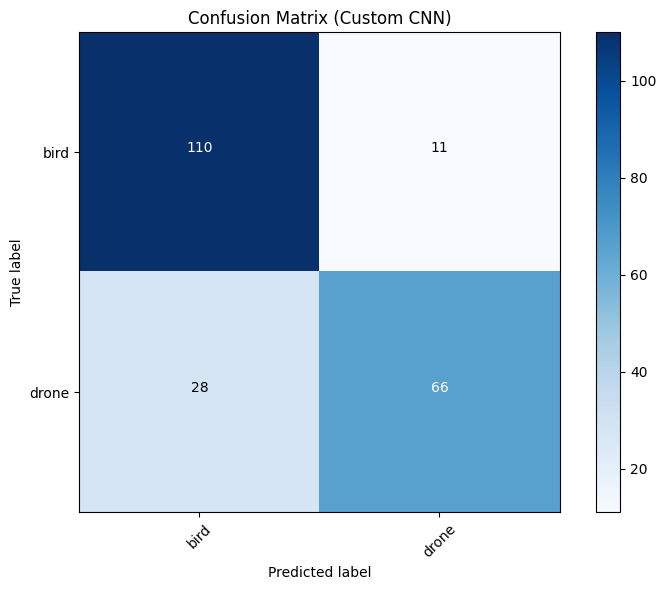


## 📈 Training History Plots (Custom CNN) ##


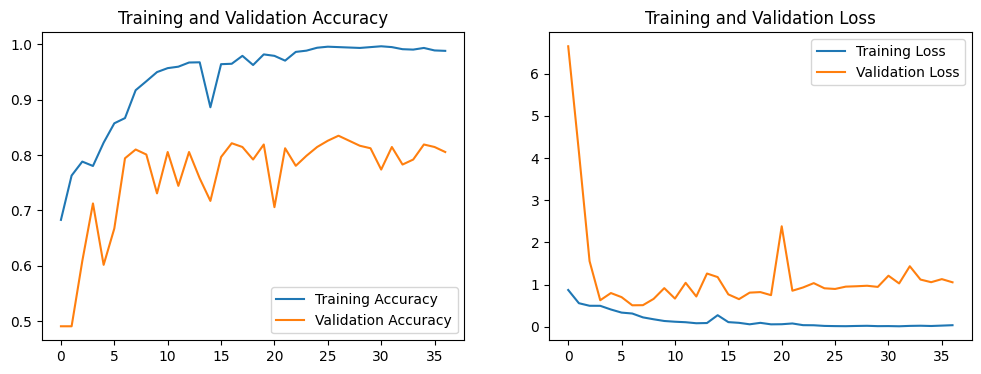


Custom CNN Evaluation Complete. Starting Transfer Learning next.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# --- 1. Evaluate Model on Test Data ---
print("Evaluating Custom CNN on the Test Dataset...")

# Ensure the best weights are loaded (they should be, thanks to EarlyStopping)
custom_cnn_model.load_weights(MODEL_SAVE_PATH)

# Predict probabilities for the test dataset
y_pred_probs = custom_cnn_model.predict(test_ds_prepped)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels
true_labels = []
for images, labels in test_ds_prepped:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(true_labels)


# --- 2. Classification Report and Confusion Matrix ---

print("\n## 📋 Classification Report (Custom CNN) ##")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion matrix'

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=CLASS_NAMES, title='Confusion Matrix (Custom CNN)')


# --- 3. Plotting Accuracy and Loss Curves ---
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

print("\n## 📈 Training History Plots (Custom CNN) ##")
plot_training_history(history_custom_cnn)

print("\nCustom CNN Evaluation Complete. Starting Transfer Learning next.")

Code Cell 6: MobileNetV2 Feature Extraction and Fine-Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. Load Pre-trained Base Model (Feature Extractor) ---
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
print("MobileNetV2 Base Model loaded and frozen.")

# --- 2. Build the Full Model with Custom Top ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions, name="MobileNetV2_Transfer_Model")
transfer_model.summary()


# --- 3. Stage 1: Train the Custom Top Layers Only ---
print("\n--- STAGE 1: Training Custom Top (Frozen Base) ---")

transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

STAGE1_EPOCHS = 10
MODEL_SAVE_PATH_TL = 'best_mobilenetv2_model.keras'

early_stopping_stage1 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history_stage1 = transfer_model.fit(
    train_ds_prepped,
    validation_data=val_ds_prepped,
    epochs=STAGE1_EPOCHS,
    callbacks=[early_stopping_stage1]
)


# --- 4. Stage 2: Fine-Tuning (Unfreeze Top Layers) ---
print("\n--- STAGE 2: Fine-Tuning Top Layers (Unfrozen Base) ---")

# Unfreeze the base model
base_model.trainable = True

# Fine-tune the layers from index 100 onwards (keeping the very early layers frozen)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a very low learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.00001), # CRUCIAL: Low learning rate for small adjustments
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

TOTAL_FINE_TUNE_EPOCHS = 40

# Continue training from where Stage 1 left off
history_transfer_learning = transfer_model.fit(
    train_ds_prepped,
    validation_data=val_ds_prepped,
    epochs=TOTAL_FINE_TUNE_EPOCHS,
    initial_epoch=history_stage1.epoch[-1],
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath=MODEL_SAVE_PATH_TL, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
)

print(f"\nTransfer Learning Training Complete. Best model saved to: {MODEL_SAVE_PATH_TL}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2

# --- 1. Define Constants (Must match your setup) ---
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 2 # bird and drone
LEARNING_RATE = 1e-4
EPOCHS = 10 # You can adjust this if you want longer training
PATIENCE = 3

# NEW: Define a robust path to save the weights using the Keras 3 compatible extension
WEIGHTS_SAVE_PATH = '/content/best_mobilenet_weights.weights.h5'


# --- 2. Build the MobileNetV2 Transfer Learning Model ---
def build_transfer_model(input_shape, num_classes, learning_rate):
    # Load MobileNetV2 base without the top classification layer
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base layers for the first training stage
    base_model.trainable = False

    # Add the new classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dropout(0.25)(x)

    output = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the model
mobilenet_model = build_transfer_model(INPUT_SHAPE, NUM_CLASSES, LEARNING_RATE)

print("MobileNetV2 Transfer Learning Model defined and compiled (Stage 1: Base Frozen).")
print(mobilenet_model.summary())


# --- 3. Define Callbacks ---
# ModelCheckpoint: Saves ONLY the best weights into the Keras 3 compatible file format
checkpoint_callback = ModelCheckpoint(
    filepath=WEIGHTS_SAVE_PATH,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# EarlyStopping: Stops training if val_loss doesn't improve
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# --- 4. Start Training (Stage 1) ---
print("\nStarting Training (Stage 1: Frozen Base)...")

history = mobilenet_model.fit(
    train_ds_prepped,
    epochs=EPOCHS,
    validation_data=val_ds_prepped,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

print(f"\nMobileNetV2 Training Complete. Best weights saved to: {WEIGHTS_SAVE_PATH}")

MobileNetV2 Transfer Learning Model defined and compiled (Stage 1: Base Frozen).


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

Starting Training (Stage 1: Frozen Base)...
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5741 - loss: 0.7935
Epoch 1: val_loss improved from inf to 0.39927, saving model to /content/best_mobilenet_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.5750 - loss: 0.7920 - val_accuracy: 0.8484 - val_loss: 0.3993
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8143 - loss: 0.4345
Epoch 2: val_loss improved from 0.39927 to 0.26755, saving model to /content/best_mobilenet_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8144 - loss: 0.4340 - val_accuracy: 0.9299 - val_loss: 0.2676
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8826 - loss: 0.3060
Epoch 3: val_loss improved from 0.26755 to 0.21084, saving model to /content/best_mobilenet_weights.weights.h5
84/84 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8827 - loss: 0.3057 - val_accuracy: 0.9412 - val_loss: 0.2108
Epoch 4/10
84/84 ━━━━━━━